In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model


In [2]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
tau_x_1 = False
N = 8
model_type = 'best'
extra_name = ''
if tau_x_1:
    extra_name = '_tau_x_1'
hidden = [200, 200, 50, 50]

## if hidden = [200, 200, 50], uncomment the following 3 lines
# hidden = [200,200,50]
# extra_name = '_no_fourth_layer'
# tau_x_1 = False

#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/trained_models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1, hidden).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [3]:
#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
feat_names = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            feat_names.append('tau_'+str(i+1)+'_'+str(0.5))
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
        else:
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
else:
    for i in range(N-1):
        feat_names.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(feat_names, ['background_prob', 'signal_prob']))
feats = df_test.drop(columns=['background_prob', 'signal_prob'])
means = np.array(df_test.mean(0))

In [4]:
def eval2(model, mask_index = -1, mask_mode = 'mean'):
    data = np.copy(feats)
    if mask_index >= 0 and mask_index < len(feat_names):
        if mask_mode == 'mean':
            data[:, mask_index] = means[mask_index]
        else:
            data[:, mask_index] = 0.
    data = torch.tensor(data, dtype = torch.float32).cuda()
    
    with torch.no_grad():
        model.eval()
        data = model.dense1(data)
        data = model.relu(data)
        data = model.dropout2(data)
    
        data = model.dense2(data)
        data = model.relu(data)
        data = model.dropout2(data)

        data = model.dense3(data)
        data = model.relu(data)
        data = model.dropout1(data)
        
        if len(model.hidden) == 4:
            data = model.dense4(data)
            data = model.relu(data)
            data = model.dropout1(data)

        data = model.dense5(data)
        presoftmax = data.cpu().numpy()
        data = model.softmax(data)
        result = data.cpu().numpy()

    
    return presoftmax, result

def dAUC_chart(dAUC_vals, tags, tag, save=False):
    tag = "baseline" if tag == "" else tag.strip('_')
    dAUC_vals = dAUC_vals[::-1]
    tags = tags[::-1]
    pos = np.arange(len(dAUC_vals))
    plt.figure(figsize=(5,5))
    plt.barh(pos, dAUC_vals, align='center')
    plt.yticks(pos, tags, fontsize = 10)
    plt.xlabel('Percent Drop in AUC', fontsize=10)
    plt.ylabel('Features', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dAUC_MB8S_{}.png".format(tag))
    plt.show()

In [5]:
baseline_presoftmax, baseline_results = eval2(model)
auc_baseline = roc_auc_score(labels[:, 0], baseline_results[:, 0])*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 97.9805%


In [6]:
dresult_presoftmax = []
dresult = []
dAUC_vals = []
for fid, feat in enumerate(feat_names):
    this_presoftmax, this_results = eval2(model, mask_index = fid, mask_mode='mean')
    dresult_presoftmax.append((this_presoftmax - baseline_presoftmax)/baseline_presoftmax)
    dresult.append(this_results - baseline_results)
    this_auc = roc_auc_score(labels[:,0], this_results[:,0])*100
    dAUC_vals.append(auc_baseline - this_auc)

ptmass


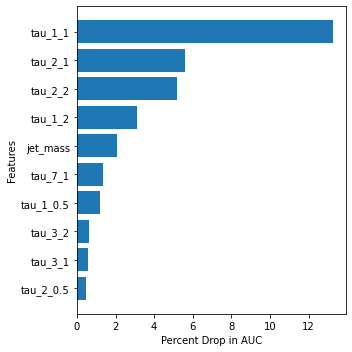

In [7]:
sorted_tags = []
sorted_vals = []
for val, tag in sorted(zip(dAUC_vals, feat_names), reverse = True)[:10]:
    sorted_tags.append(tag)
    sorted_vals.append(val)
    
tag = ('pt' if use_jet_pt else '') + ('mass' if use_jet_mass else '') + ('_' + extra_name.strip('_') if extra_name else '')
print(tag)
dAUC_chart(sorted_vals, sorted_tags, tag=tag, save=False)

In [8]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.nanquantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def plotmaker(data, tags, plot_type = 'abs_bar', part_dataset = 'bkg', save = False, modelnamesuffix = ""):
    modelnamesuffix = 'baseline' if not modelnamesuffix else modelnamesuffix
    if plot_type == 'abs_bar':
        data_no_outlier = removeOutliers(data)
        plt.figure(figsize=(5,5))
        abs_data = np.nanmean(np.abs(data_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=tags, rels=abs_data))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("MAD Relevance Score", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        # plt.title("TopoDNN Absolute Value "+type_set+" Delta LRP values")
        if save:
            plt.savefig("figures/dLRP_MB8S_{}_{}_absbar.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()
    if plot_type == 'box_whisker':
        plt.figure(figsize=(10,10))
        df_rel_total = pd.DataFrame(removeOutliers(data), columns=tags)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(data, columns=tags)
        df_rel_total = df_rel[sorted_index[:20]]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("TopoDNN "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        if save:
            plt.savefig("figures/dLRP_MB8S_{}_{}_boxwhisker.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()

In [9]:
bkg_indices = labels[:,0] == 1
sig_indices = labels[:,0] == 0
dresult_presoftmax_bkg = []
dresult_presoftmax_sig = []
dresult_bkg = []
dresult_sig = []
for idx in range(len(feat_names)):
    dresult_presoftmax_bkg.append(dresult_presoftmax[idx][bkg_indices][:,0])
    dresult_presoftmax_sig.append(dresult_presoftmax[idx][sig_indices][:,1])
    dresult_bkg.append(dresult[idx][bkg_indices][:,0])
    dresult_sig.append(dresult[idx][sig_indices][:,1])

In [10]:
dresult_presoftmax_bkg = np.transpose(np.array(dresult_presoftmax_bkg))
dresult_presoftmax_sig = np.transpose(np.array(dresult_presoftmax_sig))
dresult_bkg = np.transpose(np.array(dresult_bkg))
dresult_sig = np.transpose(np.array(dresult_sig))

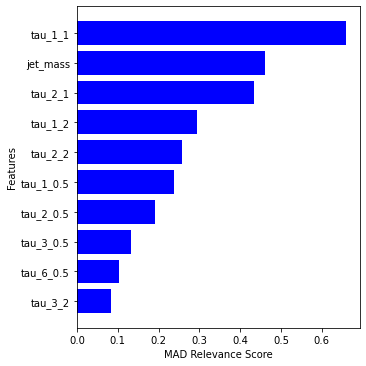

In [11]:
plotmaker(data = dresult_presoftmax_bkg, tags = feat_names, 
          plot_type = 'abs_bar', part_dataset = 'bkg', 
          save = False, modelnamesuffix = tag)

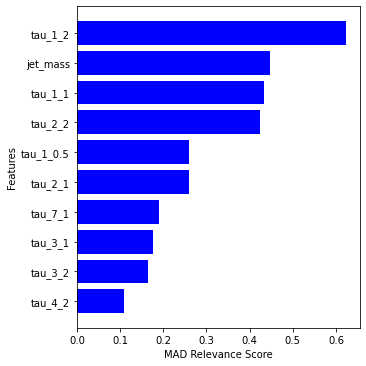

In [12]:
plotmaker(data = dresult_presoftmax_sig, tags = feat_names, 
          plot_type = 'abs_bar', part_dataset = 'sig', 
          save = False, modelnamesuffix = tag)